In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

In [2]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('p_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

72952
arrival_identifier                int64
avg_noise_1.00                  float64
avg_noise_10.00                 float64
avg_noise_11.00                 float64
avg_noise_12.00                 float64
avg_noise_13.00                 float64
avg_noise_14.00                 float64
avg_noise_15.00                 float64
avg_noise_16.00                 float64
avg_noise_17.00                 float64
avg_noise_18.00                 float64
avg_noise_2.00                  float64
avg_noise_3.00                  float64
avg_noise_4.00                  float64
avg_noise_5.00                  float64
avg_noise_6.00                  float64
avg_noise_7.00                  float64
avg_noise_8.00                  float64
avg_noise_9.00                  float64
avg_signal_1.00                 float64
avg_signal_10.00                float64
avg_signal_11.00                float64
avg_signal_12.00                float64
avg_signal_13.00                float64
avg_signal_14.00                fl

In [3]:
# This catalog of events seems to be missing 2 events 60055267, 60071327
# ngb_event_df = pd.read_csv("NGB_events_201309_201407.csv")
# ngb_event_df

# df_ngb_old = df_original[np.isin(df_original.event_identifier, ngb_event_df.evid)]

In [4]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_5159/2636885443.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_5159/2636885443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [5]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [6]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [7]:
# Read in park and caldera boundaries
utahnet_path = "../maps/utahnet"
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1

In [8]:
# Lat/lon bounding box I could use to scale the source locations
bb_lat_min = ys_border.Latitude.min() - 0.2
bb_lat_max = ys_border.Latitude.max()
bb_lon_min = ys_border.Longitude.min() - 0.15
bb_lon_max = ys_border.Longitude.max()
ys_bb = [[bb_lon_max, bb_lat_max], [bb_lon_max, bb_lat_min], [bb_lon_min, bb_lat_min], [bb_lon_min, bb_lat_max], [bb_lon_max, bb_lat_max]]

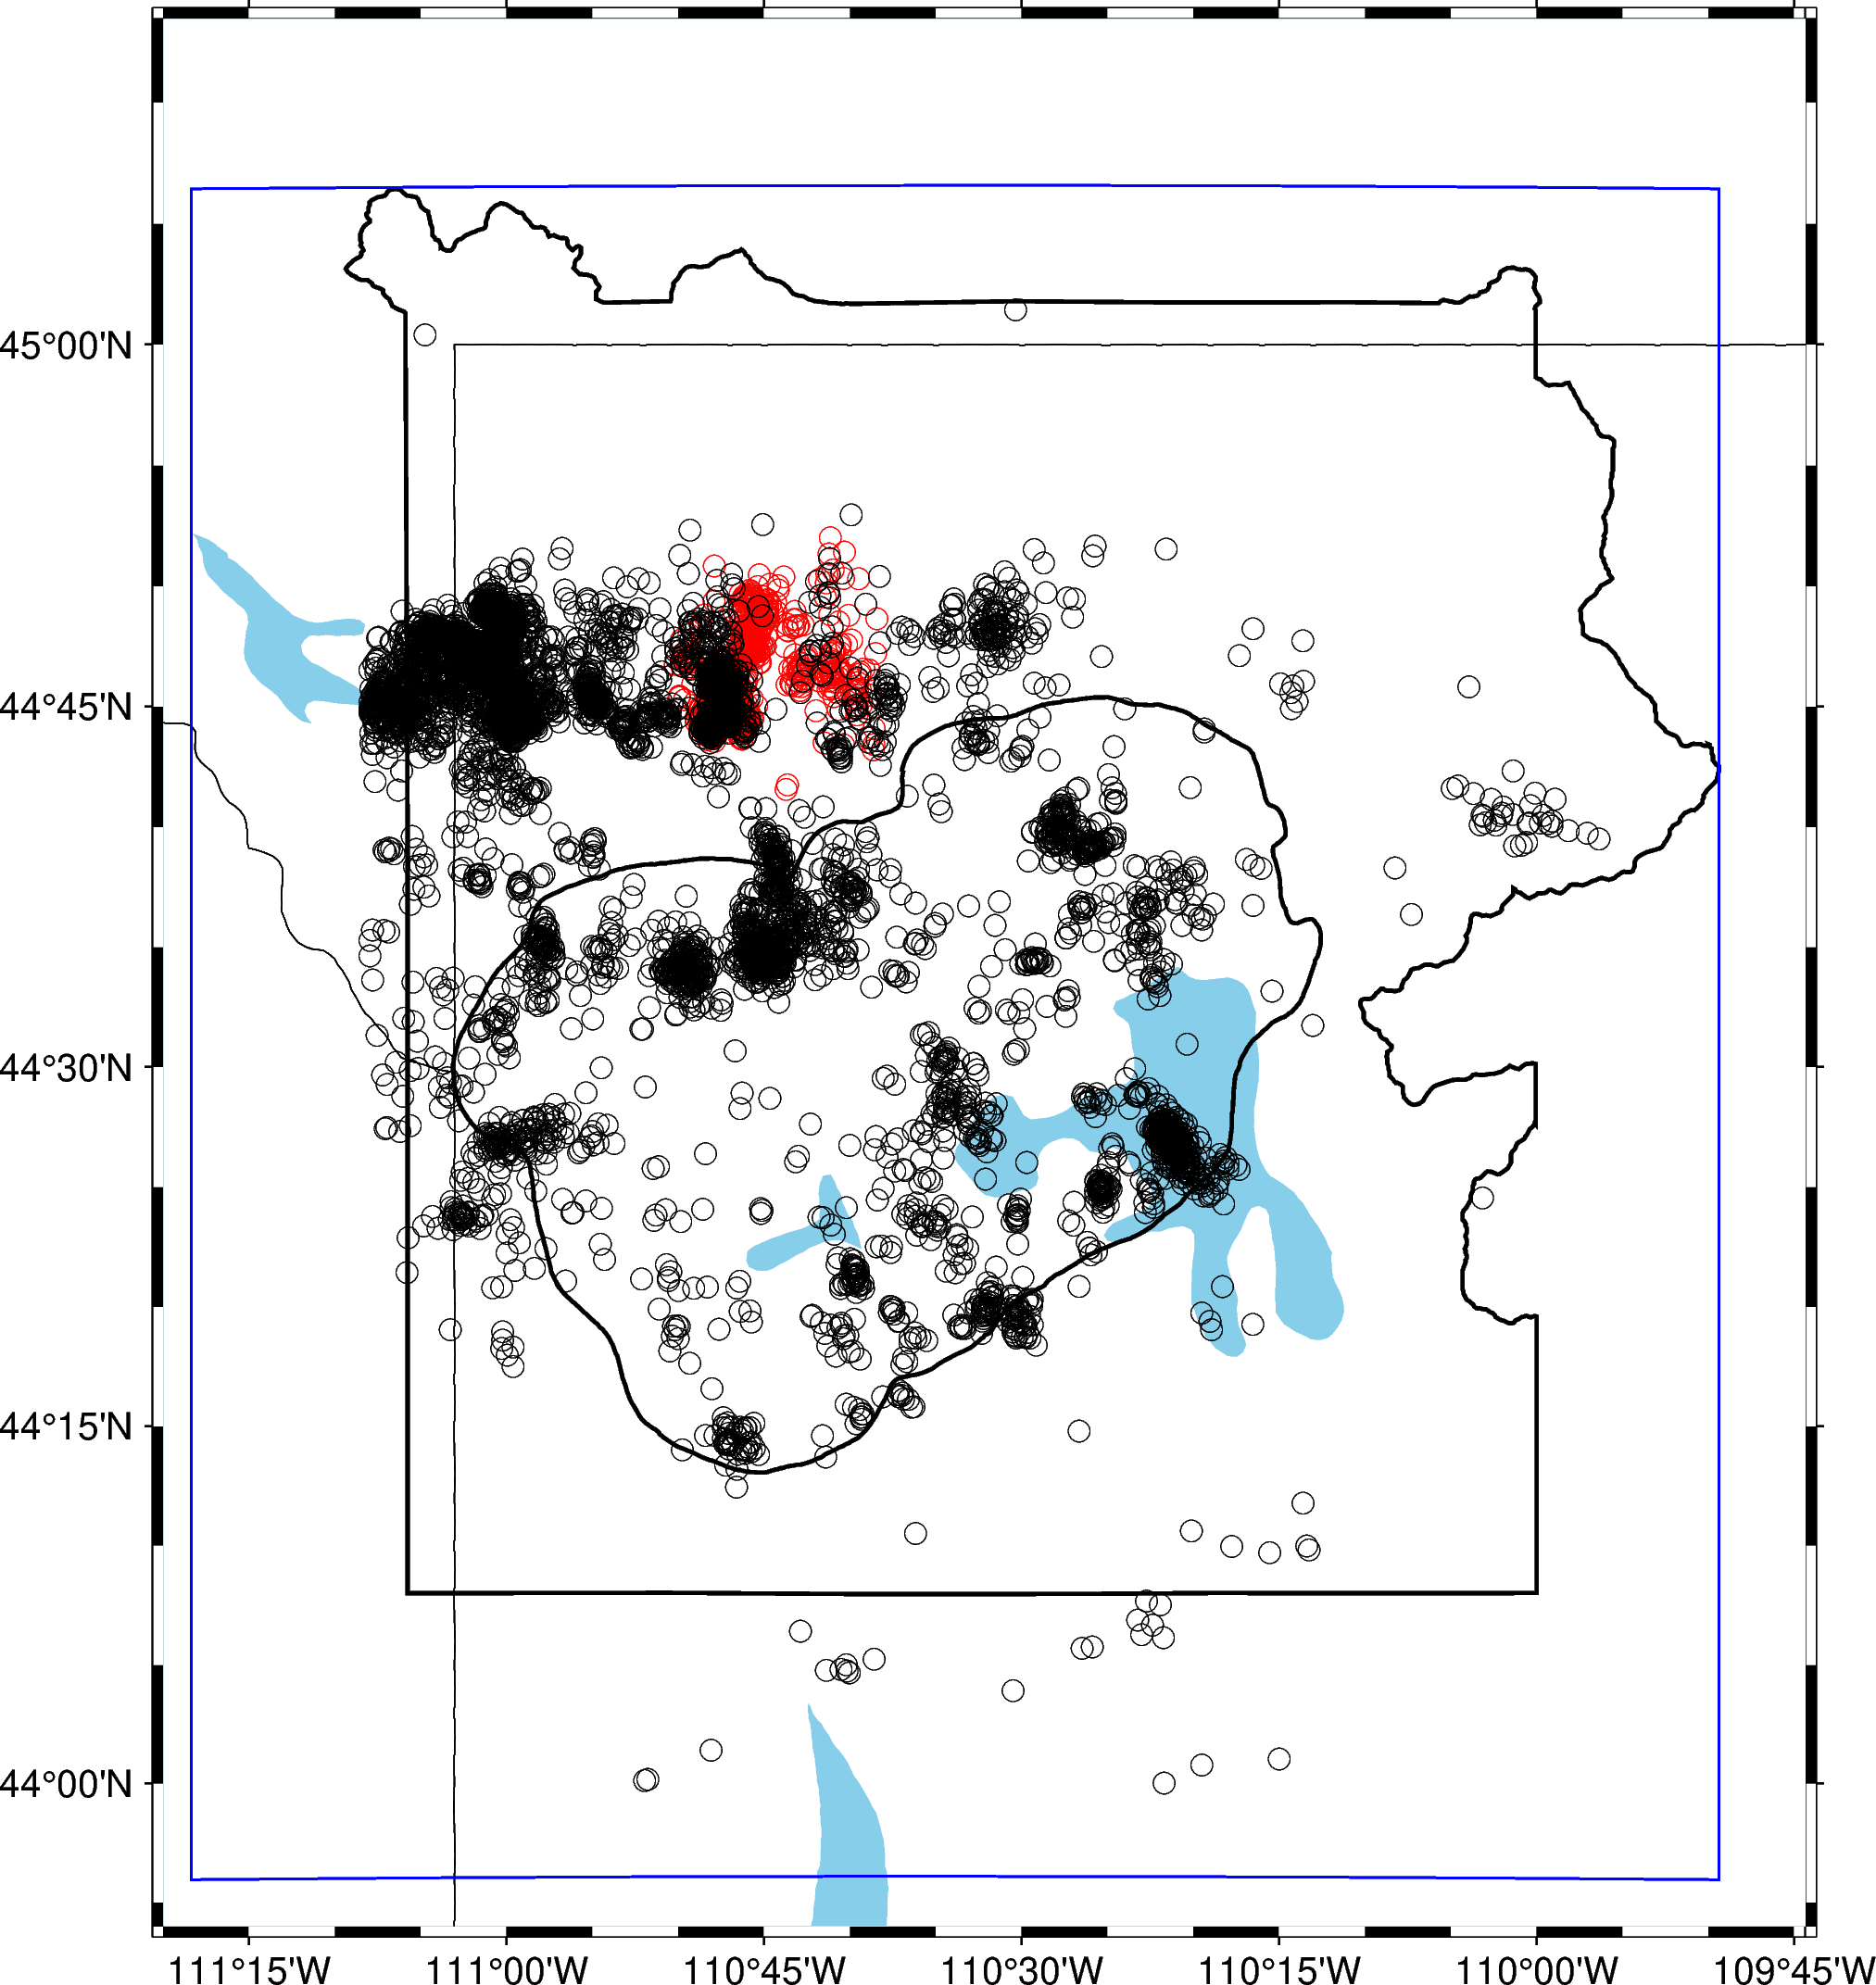

In [9]:
#Draw event map 
region = [
    eq_locs_df.event_lon.min() - 0.2,
    eq_locs_df.event_lon.max() + 0.2,
    eq_locs_df.event_lat.min() - 0.1,
    eq_locs_df.event_lat.max() + 0.2,
]

unique_locations = df_ngb_removed[["source_longitude", "source_latitude"]].drop_duplicates()
unique_ngb_locations = df_ngb[["source_longitude", "source_latitude"]].drop_duplicates()

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="white", borders=2, water="skyblue")
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black')
fig.plot(x=unique_ngb_locations.source_longitude, y=unique_ngb_locations.source_latitude, style="c0.2c", pen="0.2p,red")
fig.plot(x=unique_locations.source_longitude, y=unique_locations.source_latitude, style="c0.2c", pen="0.2p,black")
fig.plot(ys_bb, pen="0.6p,blue")
fig.show()

In [10]:
# Keep stations with more than 350 observations
stat_counts = df_original.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 350])]

## Feature selection?

In [11]:
# Make train and test datasets

test_size = 0.2
station = "YDC"

station_df = df_org_filtcounts[df_org_filtcounts.station == station]

evids = np.unique(station_df.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

train_inds = np.isin(station_df.event_identifier, train_evids)
train_df = station_df[train_inds]
test_df = station_df[~train_inds]

assert len(train_df.event_identifier.unique()) == len(train_evids)
assert len(test_df.event_identifier.unique()) == len(test_evids)
assert len(test_df) + len(train_df) == len(station_df)

In [12]:
# Computes the feature matrix from a dataframe
def compute_feature_df(df, scaler = True):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 48
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
    X[:,1]  = np.log(df['avg_signal_2.00']) - np.log(df['avg_noise_2.00'])
    X[:,2]  = np.log(df['avg_signal_3.00']) - np.log(df['avg_noise_3.00'])
    X[:,3]  = np.log(df['avg_signal_4.00']) - np.log(df['avg_noise_4.00'])
    X[:,4]  = np.log(df['avg_signal_5.00']) - np.log(df['avg_noise_5.00'])
    X[:,5]  = np.log(df['avg_signal_6.00']) - np.log(df['avg_noise_6.00'])
    X[:,6]  = np.log(df['avg_signal_7.00']) - np.log(df['avg_noise_7.00'])
    X[:,7]  = np.log(df['avg_signal_8.00']) - np.log(df['avg_noise_8.00'])
    X[:,8]  = np.log(df['avg_signal_9.00']) - np.log(df['avg_noise_9.00'])
    X[:,9]  = np.log(df['avg_signal_10.00']) - np.log(df['avg_noise_10.00'])
    X[:,10] = np.log(df['avg_signal_11.00']) - np.log(df['avg_noise_11.00'])
    X[:,11] = np.log(df['avg_signal_12.00']) - np.log(df['avg_noise_12.00'])
    X[:,12] = np.log(df['avg_signal_13.00']) - np.log(df['avg_noise_13.00'])
    X[:,13] = np.log(df['avg_signal_14.00']) - np.log(df['avg_noise_14.00'])
    X[:,14] = np.log(df['avg_signal_15.00']) - np.log(df['avg_noise_15.00'])
    X[:,15] = np.log(df['avg_signal_16.00']) - np.log(df['avg_noise_16.00'])
    X[:,16] = np.log(df['avg_signal_17.00']) - np.log(df['avg_noise_17.00'])
    X[:,17] = np.log(df['avg_signal_18.00']) - np.log(df['avg_noise_18.00'])
    # Look at amplitudes
    X[:,18] = np.log(df['avg_signal_1.00']) 
    X[:,19] = np.log(df['avg_signal_2.00']) 
    X[:,20] = np.log(df['avg_signal_3.00']) 
    X[:,21] = np.log(df['avg_signal_4.00']) 
    X[:,22] = np.log(df['avg_signal_5.00'])
    X[:,23] = np.log(df['avg_signal_6.00'])
    X[:,24] = np.log(df['avg_signal_7.00'])
    X[:,25] = np.log(df['avg_signal_8.00'])
    X[:,26] = np.log(df['avg_signal_9.00'])
    X[:,27] = np.log(df['avg_signal_10.00'])
    X[:,28] = np.log(df['avg_signal_11.00'])
    X[:,29] = np.log(df['avg_signal_12.00'])
    X[:,30] = np.log(df['avg_signal_13.00'])
    X[:,31] = np.log(df['avg_signal_14.00'])
    X[:,32] = np.log(df['avg_signal_15.00'])
    X[:,33] = np.log(df['avg_signal_16.00'])
    X[:,34] = np.log(df['avg_signal_17.00'])
    X[:,35] = np.log(df['avg_signal_18.00'])
    # Frequency and max amplitude
    X[:,36] = np.log(df['signal_dominant_frequency'])
    X[:,37] = np.log(df['signal_dominant_amplitude'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,38] = np.log(df['noise_maximum_value']  - df['noise_minimum_value'])
    X[:,39] = np.log(df['signal_maximum_value'] - df['signal_minimum_value'])
    X[:,40] = np.log(df['signal_variance'])
    X[:,41] = np.log(df['noise_variance'])
    # Source/recv distance (take log to flatten this)
    X[:,42] = np.log(df['source_receiver_distance_km'])
    X[:,43] = df['source_depth_km']
    # Single stations can learn location
    X[:,44] = df['source_latitude']
    X[:,45] = df['source_longitude']
    X[:,46] = np.sin(df['source_receiver_back_azimuth'])
    X[:,47] = df['source_receiver_back_azimuth']

    
    # Standardize features
    if (scaler):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        X = scaler.transform(X)
        return X, scaler
    
    return X
    
#X, scaler = compute_feature_matrix(df)

In [13]:
train_feat_matrix_scaled, scaler = compute_feature_df(train_df)
train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)

train_y = train_df.magnitude.values

In [14]:
train_feat_matrix_scaled[0], train_feat_matrix_unscaled[0]

(array([ 1.1026933 ,  2.17122067,  1.58729999,  1.51204435,  1.26896465,
         0.89594304,  0.60616062,  0.42759998,  0.1624905 , -0.05143539,
        -0.2096607 , -0.32233986, -0.3934105 , -0.43533177, -0.45500156,
        -0.46053146, -0.45744682, -0.44932231,  1.04814114,  1.25086795,
         0.6064961 ,  0.47612743,  0.36490414,  0.20715934,  0.02602482,
        -0.12066228, -0.22312276, -0.29589991, -0.35569923, -0.40515263,
        -0.44619283, -0.47987121, -0.50787211, -0.53158911, -0.55142999,
        -0.56758627, -0.66165493,  0.2021025 , -0.90449037,  0.1357588 ,
         0.15334366, -0.85827916,  1.58230956,  2.64016647, -3.75867825,
        -0.49294329, -1.41162622,  3.52180706]),
 array([   2.67235713,    3.80892128,    3.87997872,    4.22212932,
           4.45062199,    4.29889612,    4.1010712 ,    3.93330389,
           3.60379057,    3.28911525,    3.01673236,    2.79018222,
           2.61413185,    2.48090749,    2.38432467,    2.31504253,
           2.26588462,

In [15]:
train_y

array([2.06, 1.97, 2.03, ..., 1.63, 1.62, 0.87])

In [16]:
train_feat_df = pd.DataFrame(train_feat_matrix_scaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km","source_latitude", "source_longitude", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"])

In [17]:
train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km","source_latitude", "source_longitude", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"])

In [18]:
feat_target_df = train_feat_df.copy()
feat_target_df.loc[:, "magnitude"] = train_y
corr = feat_target_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,amp_ratio_01.0,amp_ratio_02.0,amp_ratio_03.0,amp_ratio_04.0,amp_ratio_05.0,amp_ratio_06.0,amp_ratio_07.0,amp_ratio_08.0,amp_ratio_09.0,amp_ratio_10.0,amp_ratio_11.0,amp_ratio_12.0,amp_ratio_13.0,amp_ratio_14.0,amp_ratio_15.0,amp_ratio_16.0,amp_ratio_17.0,amp_ratio_18.0,amp_01.0,amp_02.0,amp_03.0,amp_04.0,amp_05.0,amp_06.0,amp_07.0,amp_08.0,amp_09.0,amp_10.0,amp_11.0,amp_12.0,amp_13.0,amp_14.0,amp_15.0,amp_16.0,amp_17.0,amp_18.0,signal_dominant_frequency,signal_dominant_amplitude,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,source_depth_km,source_latitude,source_longitude,sin_receiver_back_azimuth,receiver_back_azimuth,magnitude
amp_ratio_01.0,1.000000,0.596016,0.488210,0.421578,0.378612,0.362243,0.338003,0.315803,0.297107,0.279226,0.265384,0.256094,0.249691,0.244592,0.240069,0.236199,0.233120,0.230818,0.559938,0.487799,0.434343,0.379316,0.339120,0.316256,0.296787,0.282727,0.272700,0.264982,0.259043,0.254092,0.249544,0.245094,0.240772,0.236761,0.233204,0.230164,-0.257212,0.304257,0.023604,0.300615,0.304558,0.007407,-0.199336,0.107366,0.036685,-0.225004,0.039964,-0.103999,0.247971
amp_ratio_02.0,0.596016,1.000000,0.762425,0.671491,0.592253,0.543951,0.490645,0.449515,0.421385,0.398254,0.379305,0.364114,0.351950,0.341979,0.333981,0.327977,0.323760,0.321093,0.559928,0.651994,0.608847,0.564022,0.522529,0.490132,0.455728,0.427201,0.405776,0.389599,0.377417,0.367818,0.359697,0.352354,0.345625,0.339585,0.334352,0.329980,-0.341825,0.457615,0.044243,0.448564,0.461603,0.019862,-0.239018,0.103417,0.054350,-0.254567,-0.001643,-0.148922,0.335728
amp_ratio_03.0,0.488210,0.762425,1.000000,0.838217,0.714059,0.627150,0.548615,0.498309,0.466643,0.440710,0.418716,0.400508,0.385381,0.372691,0.362566,0.355119,0.350070,0.347032,0.551930,0.621744,0.706401,0.657965,0.607087,0.562676,0.517494,0.480622,0.453075,0.432156,0.416373,0.404379,0.394685,0.386220,0.378605,0.371847,0.366034,0.361207,-0.388756,0.523044,0.036962,0.510405,0.528360,0.016429,-0.214481,0.146346,0.026867,-0.210926,0.010543,-0.101911,0.399796
amp_ratio_04.0,0.421578,0.671491,0.838217,1.000000,0.912226,0.791299,0.679295,0.606844,0.564377,0.534838,0.510665,0.490471,0.473567,0.459486,0.448318,0.440105,0.434520,0.431165,0.535573,0.598421,0.696612,0.769764,0.756986,0.716593,0.667727,0.623568,0.587529,0.558869,0.536702,0.519759,0.506376,0.495175,0.485512,0.477216,0.470276,0.464680,-0.339586,0.654429,0.094716,0.636358,0.660113,0.078527,-0.149485,0.088103,0.021215,-0.140924,-0.010821,-0.079848,0.515657
amp_ratio_05.0,0.378612,0.592253,0.714059,0.912226,1.000000,0.931528,0.816295,0.731416,0.679164,0.644665,0.618336,0.597618,0.581343,0.568294,0.558128,0.550718,0.545741,0.542839,0.544555,0.594320,0.691890,0.796767,0.832897,0.817932,0.781836,0.743556,0.709620,0.681372,0.658931,0.641518,0.627730,0.616293,0.606540,0.598274,0.591450,0.586025,-0.257249,0.760749,0.131027,0.745430,0.766326,0.110739,-0.149211,0.104866,0.034787,-0.132371,-0.029062,-0.080281,0.586819
amp_ratio_06.0,0.362243,0.543951,0.627150,0.791299,0.931528,1.000000,0.954326,0.884761,0.830518,0.791204,0.761276,0.738779,0.722256,0.709654,0.700090,0.693189,0.688528,0.685739,0.581148,0.615173,0.696712,0.797537,0.851392,0.872114,0.863695,0.842057,0.818846,0.798103,0.780873,0.767020,0.755764,0.746291,0.738144,0.731197,0.725432,0.720830,-0.157146,0.844250,0.125509,0.834990,0.851758,0.097161,-0.211414,0.159138,0.077350,-0.189158,-0.034706,-0.133068,0.633267
amp_ratio_07.0,0.338003,0.490645,0.548615,0.679295,0.816295,0.954326,1.000000,0.976234,0.935799,0.898001,0.866141,0.841343,0.823043,0.809299,0.798997,0.791517,0.786296,0.782903,0.598122,0.617560,0.683357,0.770898,0.825179,0.863488,0.877982,0.873662,0.862416,0.850199,0.839048,0.829535,0.821533,0.814679,0.808710,0.803553,0.799217,0.795711,-0.074824,0.863768,0.090333,0.861431,0.874739,0.057921,-0.265280,0.200301,0.111734,-0.238476,-0.036032,-0.175035,0.641129
amp_ratio_08.0,0.315803,0.449515,0.498309,0.606844,0.731416,0.884761,0.976234,1.

In [19]:
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector, RFE

In [20]:
mutual_reg = mutual_info_regression(train_feat_matrix_scaled, train_y, random_state=843824)
mutual_reg

array([0.0341609 , 0.0821808 , 0.09720451, 0.17861405, 0.24056037,
       0.28587312, 0.28610145, 0.26029615, 0.26466984, 0.27833707,
       0.23758829, 0.24817987, 0.2683465 , 0.24304882, 0.23608793,
       0.23538105, 0.24059295, 0.27514079, 0.22442278, 0.25328811,
       0.27096547, 0.38468535, 0.37550693, 0.37305298, 0.35579294,
       0.35738071, 0.33077012, 0.32018683, 0.32026736, 0.32329449,
       0.33052743, 0.32071266, 0.31962477, 0.31481778, 0.31956149,
       0.33389422, 0.00508775, 0.34135622, 0.02768268, 0.32459562,
       0.3553295 , 0.02341844, 0.10198201, 0.03277416, 0.04573946,
       0.05713786, 0.        , 0.0190073 ])

In [21]:
train_feat_df.columns[np.argsort(mutual_reg, axis=0)]

Index(['sin_receiver_back_azimuth', 'signal_dominant_frequency',
       'receiver_back_azimuth', 'noise_variance', 'noise_max_amplitude',
       'source_depth_km', 'amp_ratio_01.0', 'source_latitude',
       'source_longitude', 'amp_ratio_02.0', 'amp_ratio_03.0',
       'source_receiver_distance_logkm', 'amp_ratio_04.0', 'amp_01.0',
       'amp_ratio_16.0', 'amp_ratio_15.0', 'amp_ratio_11.0', 'amp_ratio_05.0',
       'amp_ratio_17.0', 'amp_ratio_14.0', 'amp_ratio_12.0', 'amp_02.0',
       'amp_ratio_08.0', 'amp_ratio_09.0', 'amp_ratio_13.0', 'amp_03.0',
       'amp_ratio_18.0', 'amp_ratio_10.0', 'amp_ratio_06.0', 'amp_ratio_07.0',
       'amp_16.0', 'amp_17.0', 'amp_15.0', 'amp_10.0', 'amp_11.0', 'amp_14.0',
       'amp_12.0', 'signal_max_amplitude', 'amp_13.0', 'amp_09.0', 'amp_18.0',
       'signal_dominant_amplitude', 'signal_variance', 'amp_07.0', 'amp_08.0',
       'amp_06.0', 'amp_05.0', 'amp_04.0'],
      dtype='object')

In [24]:
# Make cross validation splits across evids

from sklearn.model_selection import KFold
evids = train_df.event_identifier.unique()
kf = KFold(n_splits=5, shuffle=True, random_state=843824)
folds = []
for train_index, test_index in kf.split(evids):
    # Get the evids corresponding to the split indicies
    fold_train_evids = evids[train_index]
    fold_test_evids = evids[test_index]
    # Get rows of training dataset that correspond to split evids
    fold_train_inds = np.where(np.isin(train_df.event_identifier, fold_train_evids))[0]
    fold_test_inds = np.where(np.isin(train_df.event_identifier, fold_test_evids))[0]
    
    folds.append((fold_train_inds, fold_test_inds))

In [25]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import r2_score

## RFE

from RFECV, know that most of the gain comes from 5-10 features. Use RFE to find 8 "best" features

In [24]:
train_feat_df.columns[:-1]

Index(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_03.0', 'amp_ratio_04.0',
       'amp_ratio_05.0', 'amp_ratio_06.0', 'amp_ratio_07.0', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_ratio_12.0',
       'amp_ratio_13.0', 'amp_ratio_14.0', 'amp_ratio_15.0', 'amp_ratio_16.0',
       'amp_ratio_17.0', 'amp_ratio_18.0', 'amp_01.0', 'amp_02.0', 'amp_03.0',
       'amp_04.0', 'amp_05.0', 'amp_06.0', 'amp_07.0', 'amp_08.0', 'amp_09.0',
       'amp_10.0', 'amp_11.0', 'amp_12.0', 'amp_13.0', 'amp_14.0', 'amp_15.0',
       'amp_16.0', 'amp_17.0', 'amp_18.0', 'signal_dominant_frequency',
       'signal_dominant_amplitude', 'noise_max_amplitude',
       'signal_max_amplitude', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm', 'source_depth_km', 'source_latitude',
       'source_longitude', 'sin_receiver_back_azimuth'],
      dtype='object')

In [25]:
# Find best features for whole training dataset
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=8, step=1)
selector = selector.fit(train_feat_matrix_scaled[:, :-1], train_y)

train_feat_df.columns[:-1][selector.support_]

Index(['amp_ratio_16.0', 'amp_ratio_18.0', 'amp_04.0', 'amp_12.0', 'amp_14.0',
       'amp_15.0', 'amp_16.0', 'amp_18.0'],
      dtype='object')

In [26]:
# Sort features by importance - first 8 are in no particular order
train_feat_df.columns[:-1][np.argsort(selector.ranking_)]

Index(['amp_18.0', 'amp_16.0', 'amp_15.0', 'amp_04.0', 'amp_14.0', 'amp_12.0',
       'amp_ratio_18.0', 'amp_ratio_16.0', 'signal_max_amplitude',
       'source_receiver_distance_logkm', 'amp_17.0', 'amp_11.0', 'amp_10.0',
       'amp_07.0', 'amp_09.0', 'amp_02.0', 'amp_ratio_15.0', 'amp_ratio_11.0',
       'amp_ratio_13.0', 'amp_ratio_09.0', 'amp_ratio_17.0', 'amp_08.0',
       'amp_ratio_08.0', 'amp_ratio_06.0', 'amp_13.0', 'amp_06.0', 'amp_05.0',
       'amp_01.0', 'noise_max_amplitude', 'amp_ratio_04.0', 'source_longitude',
       'signal_variance', 'signal_dominant_frequency', 'source_latitude',
       'amp_ratio_03.0', 'amp_03.0', 'amp_ratio_02.0', 'amp_ratio_12.0',
       'amp_ratio_01.0', 'amp_ratio_05.0', 'amp_ratio_14.0', 'noise_variance',
       'amp_ratio_10.0', 'amp_ratio_07.0', 'source_depth_km',
       'signal_dominant_amplitude', 'sin_receiver_back_azimuth'],
      dtype='object')

In [27]:
# Training performace with these 8 features in the linear model 
r2_score(selector.predict(train_feat_matrix_scaled[:, :-1]), train_y)

0.1931836148889583

In [28]:
# CV performace with these 8 features in non-linear model
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, :-1][:, selector.support_], train_y, cv=folds, scoring="r2")

{'fit_time': array([0.11417842, 0.11130762, 0.11238694, 0.10969019, 0.11297941]),
 'score_time': array([0.02253199, 0.02222657, 0.02233791, 0.02166128, 0.02264333]),
 'test_score': array([0.63708932, 0.59162483, 0.57956925, 0.48455884, 0.53869828])}

In [29]:
# Get best RFE features for various folds and evaluate 
for fold in folds:
    # Pipeline for choosing features for fold
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=8, step=1)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('selector', selector)])
    
    # Fold data - exclude receiver_back_azimuth since linear model
    cv_train_X = train_feat_matrix_unscaled[fold[0], :-1]
    cv_train_y = train_y[fold[0]]
    cv_test_X = train_feat_matrix_unscaled[fold[1], :-1]
    cv_test_y = train_y[fold[1]]
    
    # Fit selector to fold training data
    s = pipeline.fit(cv_train_X, cv_train_y)
    # Make predictions on the fold test data
    preds = s.predict(cv_test_X)
    # Get the features for this model
    support = s.named_steps.selector.support_
    # Print the features
    print(train_feat_df.columns[:-1][support])
    # Print the test R^2 score
    print(r2_score(cv_test_y, preds))
    
    # Use this features in a non-linear model. Cross validate over all the folds
    svr = SVR(C=1.0, epsilon=0.2)
    nl_pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    print(cross_validate(nl_pipeline, train_feat_matrix_unscaled[:, :-1][:, support],
                         train_y, cv=folds, scoring="r2")["test_score"])

Index(['amp_ratio_16.0', 'amp_ratio_18.0', 'amp_04.0', 'amp_12.0', 'amp_15.0',
       'amp_16.0', 'amp_18.0', 'signal_max_amplitude'],
      dtype='object')
0.6220806314131345
[0.67473319 0.63298634 0.60658769 0.51783804 0.56166575]
Index(['amp_ratio_16.0', 'amp_ratio_18.0', 'amp_04.0', 'amp_12.0', 'amp_14.0',
       'amp_15.0', 'amp_16.0', 'amp_18.0'],
      dtype='object')
0.5596900634657396
[0.63708932 0.59162483 0.57956925 0.48455884 0.53869828]
Index(['amp_ratio_12.0', 'amp_ratio_13.0', 'amp_ratio_16.0', 'amp_ratio_18.0',
       'amp_12.0', 'amp_15.0', 'amp_16.0', 'amp_18.0'],
      dtype='object')
0.4358199812146558
[0.49737494 0.44143011 0.43653193 0.3415267  0.41678988]
Index(['amp_ratio_16.0', 'amp_ratio_18.0', 'amp_04.0', 'amp_12.0', 'amp_14.0',
       'amp_15.0', 'amp_18.0', 'signal_max_amplitude'],
      dtype='object')
0.45036597126515865
[0.67306    0.63167272 0.60526084 0.51704624 0.56070222]
Index(['amp_ratio_16.0', 'amp_ratio_18.0', 'amp_05.0', 'amp_06.0', 'amp_12.0',


## Sequential Feature Selection. 
Forward selection until change in score is less than 1e-4 or reach half of the features. Slightly better CV performace with 13 features than 46 for non-linear SVR. Pretty comparable performace between the 13 and 46 features in linear SVR. 

In [30]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-3, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled, train_y)

sfs.get_feature_names_out(train_feat_df.columns)

array(['amp_ratio_18.0', 'amp_01.0', 'amp_03.0', 'amp_04.0', 'amp_07.0',
       'amp_10.0', 'amp_18.0', 'signal_max_amplitude',
       'source_receiver_distance_logkm', 'source_latitude',
       'source_longitude'], dtype=object)

In [31]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.0901649 , 0.08352327, 0.08409548, 0.0815165 , 0.08330297]),
 'score_time': array([0.01487327, 0.0139482 , 0.01379585, 0.01350498, 0.01452565]),
 'test_score': array([0.88397057, 0.85581737, 0.84955743, 0.81913662, 0.85642935])}

In [32]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-4, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled, train_y)

sfs.get_feature_names_out(train_feat_df.columns)

array(['amp_ratio_18.0', 'amp_01.0', 'amp_03.0', 'amp_04.0', 'amp_07.0',
       'amp_10.0', 'amp_18.0', 'signal_max_amplitude',
       'source_receiver_distance_logkm', 'source_latitude',
       'source_longitude'], dtype=object)

In [33]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.08861876, 0.08732128, 0.08193207, 0.07939386, 0.081213  ]),
 'score_time': array([0.01425719, 0.01400447, 0.01420522, 0.01363254, 0.01424694]),
 'test_score': array([0.88397057, 0.85581737, 0.84955743, 0.81913662, 0.85642935])}

In [34]:
# Result when selecting 6 features
# array(['amp_01.0', 'amp_02.0', 'amp_12.0', 'signal_dominant_amplitude',
#        'source_receiver_distance_logkm', 'source_longitude'], dtype=object)
# 0.86665783, 0.86072235, 0.83637506, 0.87239198, 0.87021598

In [35]:
# Performance when using all features
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled, train_y, cv=folds)

{'fit_time': array([0.09821939, 0.09101653, 0.08847857, 0.08971381, 0.09220576]),
 'score_time': array([0.01916718, 0.01831841, 0.01676345, 0.0168283 , 0.01732254]),
 'test_score': array([0.86549819, 0.82796302, 0.8366409 , 0.79643607, 0.84301914])}

# Go more in-depth into the effect of the more important features

In [27]:
all_selected_features = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                         'source_longitude', "source_latitude", 'source_receiver_distance_logkm',
                         'source_depth_km', "receiver_back_azimuth", "amp_01.0", 
                         'amp_02.0','amp_12.0', "amp_08.0", "amp_18.0", "amp_ratio_01.0", "amp_ratio_18.0"]

selected_features_lat_lon = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                             'source_longitude', "source_latitude", 'source_depth_km', "amp_01.0", 
                             'amp_02.0','amp_12.0', "amp_08.0", "amp_18.0", "amp_ratio_01.0", "amp_ratio_18.0"]

selected_features_sr = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                        'source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth",
                        "amp_01.0", 'amp_02.0', 'amp_12.0', "amp_08.0", "amp_18.0", "amp_ratio_01.0", "amp_ratio_18.0"]

In [28]:
def svr_cv(X, y, folds, C=1.0, epsilon=0.2):
    svr = SVR(C=C, epsilon=epsilon)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    cv_scores = cross_validate(pipeline, X, y, scoring="r2", cv=folds)["test_score"]
    
    return cv_scores

In [29]:
def seq_feature_importance(selected_features, train_feat_df_unscaled):
    feat_selection = np.copy(selected_features)
    best_features = []
    r2_maxs = []
    r2_mins = []
    r2_means = []

    for it in range(len(selected_features)):
        print("iteration", it)
        print(best_features)

        it_r2_vals = []
    #     best_feat_ind = -1

        for feature_ind in range(len(feat_selection)):
            features = [feat_selection[feature_ind]]
            if len(best_features) == 0:
                train_X = train_feat_df_unscaled[features].values.reshape(-1, 1)
            else:
                features = np.concatenate([best_features, features])
                train_X = train_feat_df_unscaled[features].values

            cv_scores = svr_cv(train_X, train_y, folds)

            mean_cv = np.mean(cv_scores)
            print(features[-1], mean_cv)
    #         if mean_cv > max_r2:
    #             best_feat_ind = feature_ind
    #             max_r2 = mean_cv

            it_r2_vals.append(mean_cv)

        best_feat_ind = np.argmax(it_r2_vals)
        best_features.append(feat_selection[best_feat_ind])
        r2_means.append(np.mean(it_r2_vals))
        r2_mins.append(np.min(it_r2_vals))
        r2_maxs.append(np.max(it_r2_vals))

        feat_selection = np.delete(feat_selection, best_feat_ind)

    n_features = np.arange(1, len(selected_features)+1)
    plt.plot(n_features, r2_means, linestyle="--", color="k", label="mean")
    plt.plot(n_features, r2_mins, color="k", label="min")
    plt.fill_between(n_features, r2_maxs, r2_mins, color="gray")
    plt.plot(n_features, r2_maxs, marker="x", color="r", label="max")
    plt.xticks(n_features) #, labels=n_features[::-1]) #, labels=best_features, rotation=45);
    plt.grid()
    plt.xlabel("N Features") #("N Features to Choose From");
    plt.ylabel(r"Mean $R^2$ of 5-fold CV");
    plt.legend();
    
    return best_features

iteration 0
[]
signal_dominant_amplitude 0.4475093036925415
signal_max_amplitude 0.45054494608557566
signal_variance 0.49123380446054404
source_longitude 0.051475630595807065
source_latitude 0.009837776550640932
source_depth_km -0.012929837869902983
amp_01.0 0.34622374842758274
amp_02.0 0.3758895435252964
amp_12.0 0.4158178494961441
amp_08.0 0.44900959268005736
amp_18.0 0.39963479808191715
amp_ratio_01.0 0.04221979527311766
amp_ratio_18.0 0.3640611695314836
iteration 1
['signal_variance']
signal_dominant_amplitude 0.5198970077559292
signal_max_amplitude 0.5183960087747406
source_longitude 0.7017308046462345
source_latitude 0.569663118631545
source_depth_km 0.5247151440061298
amp_01.0 0.5157955231473295
amp_02.0 0.5214145502144125
amp_12.0 0.5231875303718561
amp_08.0 0.5088121346986139
amp_18.0 0.5280231742160525
amp_ratio_01.0 0.49026593831451637
amp_ratio_18.0 0.5059078333460436
iteration 2
['signal_variance', 'source_longitude']
signal_dominant_amplitude 0.7150837846962579
signal_max

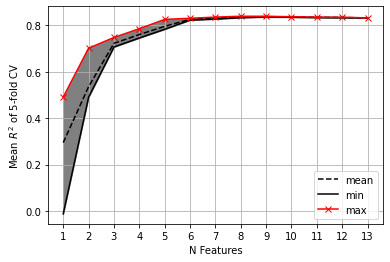

In [30]:
best_features_lat_lon = seq_feature_importance(selected_features_lat_lon, train_feat_df_unscaled)

In [40]:
# Best features when including lat, lon, and source_receiver_distance_logkm. Do not include receiver_back_azimith
# ['amp_01.0',
#  'source_longitude',
#  'amp_12.0',
#  'source_receiver_distance_logkm',
#  'amp_02.0',
#  'signal_dominant_amplitude',
#  'amp_ratio_01.0',
#  'source_latitude',
#  'amp_08.0',
#  'amp_18.0',
#  'source_depth_km',
#  'signal_max_amplitude',
#  'signal_variance']

In [31]:
best_features_lat_lon

['signal_variance',
 'source_longitude',
 'source_latitude',
 'amp_18.0',
 'amp_02.0',
 'signal_max_amplitude',
 'amp_ratio_18.0',
 'amp_12.0',
 'amp_01.0',
 'signal_dominant_amplitude',
 'amp_08.0',
 'source_depth_km',
 'amp_ratio_01.0']

iteration 0
[]
signal_dominant_amplitude 0.4475093036925415
signal_max_amplitude 0.45054494608557566
signal_variance 0.49123380446054404
source_receiver_distance_logkm 0.0841079820362032
source_depth_km -0.012929837869902983
receiver_back_azimuth -0.0034339926285375634
amp_01.0 0.34622374842758274
amp_02.0 0.3758895435252964
amp_12.0 0.4158178494961441
amp_08.0 0.44900959268005736
amp_18.0 0.39963479808191715
amp_ratio_01.0 0.04221979527311766
amp_ratio_18.0 0.3640611695314836
iteration 1
['signal_variance']
signal_dominant_amplitude 0.5198970077559292
signal_max_amplitude 0.5183960087747406
source_receiver_distance_logkm 0.739986451984971
source_depth_km 0.5247151440061298
receiver_back_azimuth 0.5677978783382918
amp_01.0 0.5157955231473295
amp_02.0 0.5214145502144125
amp_12.0 0.5231875303718561
amp_08.0 0.5088121346986139
amp_18.0 0.5280231742160525
amp_ratio_01.0 0.49026593831451637
amp_ratio_18.0 0.5059078333460436
iteration 2
['signal_variance', 'source_receiver_distance_logkm']
s

['signal_variance',
 'source_receiver_distance_logkm',
 'amp_18.0',
 'amp_02.0',
 'receiver_back_azimuth',
 'amp_ratio_18.0',
 'signal_max_amplitude',
 'amp_12.0',
 'amp_01.0',
 'source_depth_km',
 'amp_08.0',
 'signal_dominant_amplitude',
 'amp_ratio_01.0']

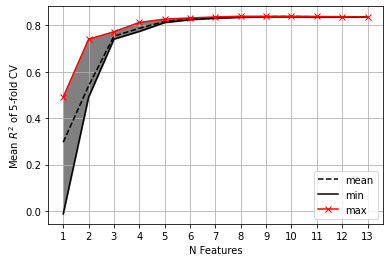

In [32]:
best_features_sr = seq_feature_importance(selected_features_sr, train_feat_df_unscaled)
best_features_sr

In [33]:
# All selected features with lat lon result
selected_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[selected_features_lat_lon], train_y, folds)
print(selected_feat_lat_lon_cv)
print(np.mean(selected_feat_lat_lon_cv))

[0.86379952 0.84329545 0.83711893 0.78702438 0.8309401 ]
0.8324356746175721


In [35]:
# Top 5 features with lat lon 
top_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[best_features_lat_lon[0:6]], train_y, folds)
print(top_feat_lat_lon_cv )
print(np.mean(top_feat_lat_lon_cv))

[0.86191298 0.84257446 0.83520774 0.79001535 0.82467569]
0.830877244127475


In [36]:
# All selected features with sr distance and back azimuth
selected_feat_sr_cv = svr_cv(train_feat_df_unscaled[selected_features_sr], train_y, folds)
print(selected_feat_sr_cv)
print(np.mean(selected_feat_sr_cv))

[0.85975419 0.84625722 0.83089235 0.80549239 0.83344435]
0.8351681000012455


In [40]:
# Top 5 selected features with sr distance and back azimuth
top_feat_sr_cv = svr_cv(train_feat_df_unscaled[best_features_sr[0:6]], train_y, folds)
print(top_feat_sr_cv )
print(np.mean(top_feat_sr_cv))

[0.86191553 0.83257211 0.8260819  0.80036006 0.83738147]
0.8316622153504394


In [38]:
selected_feat_df = train_feat_df.copy()[all_selected_features]
selected_feat_df.loc[:, "magnitude"] = train_y
corr = selected_feat_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,signal_dominant_amplitude,signal_max_amplitude,signal_variance,source_longitude,source_latitude,source_receiver_distance_logkm,source_depth_km,receiver_back_azimuth,amp_01.0,amp_02.0,amp_12.0,amp_08.0,amp_18.0,amp_ratio_01.0,amp_ratio_18.0,magnitude
signal_dominant_amplitude,1.000000,0.993813,0.990285,-0.264589,0.147818,-0.307614,0.245505,-0.218724,0.644054,0.673876,0.929901,0.974559,0.889828,0.304257,0.791327,0.651552
signal_max_amplitude,0.993813,1.000000,0.990248,-0.278847,0.162899,-0.320677,0.262543,-0.233646,0.656644,0.683536,0.941065,0.974551,0.905771,0.300615,0.810778,0.654098
signal_variance,0.990285,0.990248,1.000000,-0.267274,0.144676,-0.303985,0.247948,-0.214975,0.653688,0.682032,0.950914,0.987209,0.913255,0.304558,0.815754,0.684136
source_longitude,-0.264589,-0.278847,-0.267274,1.000000,-0.313289,0.898271,-0.415747,0.395583,-0.264726,-0.254441,-0.342661,-0.286309,-0.347255,-0.225004,-0.339051,0.206080
source_latitude,0.147818,0.162899,0.144676,-0.313289,1.000000,-0.489731,-0.068950,-0.935029,0.104975,0.117685,0.198350,0.168164,0.202746,0.036685,0.192128,-0.118848
source_receiver_distance_logkm,-0.307614,-0.320677,-0.303985,0.898271,-0.489731,1.000000,-0.352878,0.570750,-0.240020,-0.234323,-0.385175,-0.326675,-0.397196,-0.199336,-0.375189,0.245019
source_depth_km,0.245505,0.262543,0.247948,-0.415747,-0.068950,-0.352878,1.000000,0.026147,0.218192,0.191676,0.295772,0.235465,0.317100,0.107366,0.326588,0.056397
receiver_back_azimuth,-0.218724,-0.233646,-0.214975,0.395583,-0.935029,0.570750,0.026147,1.000000,-0.183958,-0.208462,-0.268821,-0.233489,-0.273742,-0.103999,-0.262263,0.115185
amp_01.0,0.644054,0.656644,0.653688,-0.264726,0.104975,-0.240020,0.218192,-0.183958,1.000000,0.918623,0.553632,0.601874,0.524985,0.559938,0.488921,0.541990
amp_02.0,0.673876,0.683536,0.682032,-0.254441,0.117685,-0.234323,0.191676,-0.208462,0.918623,1.000000,0.553401,0.620010,0.517837,0.487799,0.477390,0.553196


In [41]:
def add_feat_to_base(base_features, additional_features, all_features_cv=None, top_features_cv=None):

    cv_means = []

    for cf in additional_features:
        feat_list = base_features.copy()
        feat_list.append(cf)
        cv_vals = svr_cv(train_feat_df_unscaled[feat_list], train_y, folds)
        cv_means.append(np.mean(cv_vals))

    plt.scatter(range(len(additional_features)), cv_means, marker="x")
    plt.xticks(range(len(additional_features)), labels=additional_features, rotation=45);
    if all_features_cv is not None:
        plt.axhline(np.mean(all_features_cv))
    if top_features_cv is not None:
        plt.axhline(np.mean(top_features_cv), color="C1")
    plt.show()
    
    return cv_means

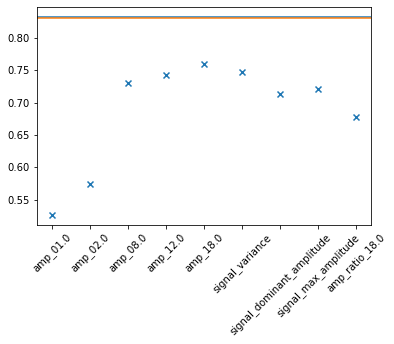

In [43]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0']

correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

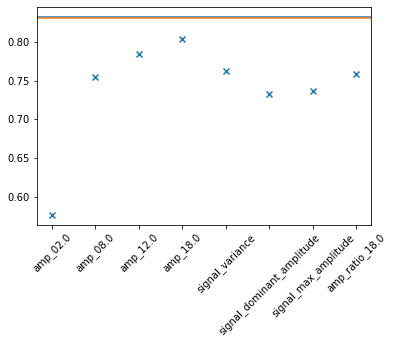

In [44]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

cv_means_amp01  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

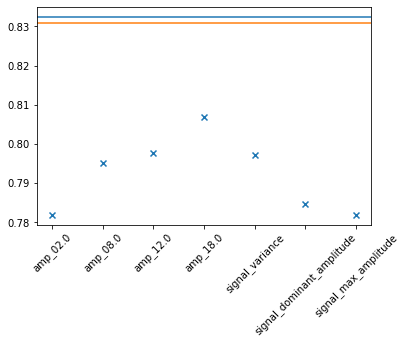

In [52]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0', "amp_01.0", "amp_ratio_18.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_amprat18  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

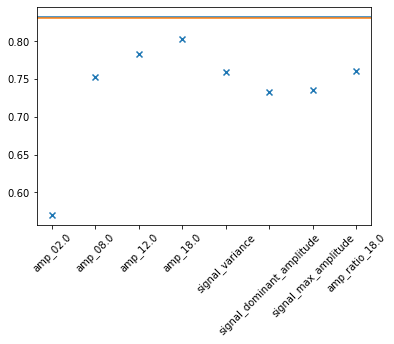

In [49]:
base_features = ['source_longitude', "source_latitude",'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

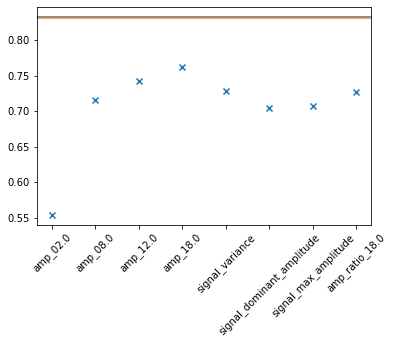

In [50]:
base_features = ['source_longitude','amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

cv_means_nodepth_nolat = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

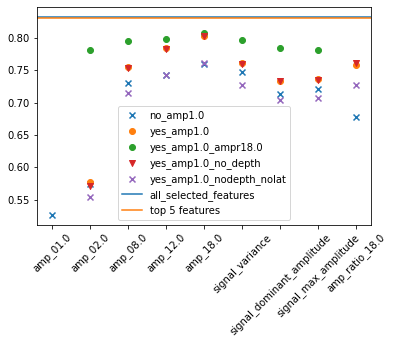

In [57]:
correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01, marker="o", label="yes_amp1.0")
plt.scatter( range(1,len(correlated_features)-1), cv_means_amprat18, marker="o", label="yes_amp1.0_ampr18.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp1.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nolat, marker="x", label="yes_amp1.0_nodepth_nolat")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_lat_lon_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_lat_lon_cv), color="C1", label="top 5 features")
plt.legend();

source_receiver_distance_logkm, source_longitude, source_latitude, 
                 source_depth_km, amp_ratio_01.0, amp_01.0, and signal_variance seem to be able to account for most of the performance gain. Some addition of the other features seems to add the extra percent. Though the other features and signal variance are highly correlated. Using depth doesn't change results. Latitude doesn't add much either.

In [60]:
fewer_features_lat_lon = ['source_longitude', "source_latitude",'amp_ratio_01.0', "amp_01.0", "signal_variance", 
                          "amp_18.0", "amp_ratio_18.0"]
fewer_feat_lat_lon_df = train_feat_df.copy()[fewer_features_lat_lon]
fewer_feat_lat_lon_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_lat_lon_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_longitude,source_latitude,amp_ratio_01.0,amp_01.0,signal_variance,amp_18.0,amp_ratio_18.0,magnitude
source_longitude,1.000000,-0.313289,-0.225004,-0.264726,-0.267274,-0.347255,-0.339051,0.206080
source_latitude,-0.313289,1.000000,0.036685,0.104975,0.144676,0.202746,0.192128,-0.118848
amp_ratio_01.0,-0.225004,0.036685,1.000000,0.559938,0.304558,0.230164,0.230818,0.247971
amp_01.0,-0.264726,0.104975,0.559938,1.000000,0.653688,0.524985,0.488921,0.541990
signal_variance,-0.267274,0.144676,0.304558,0.653688,1.000000,0.913255,0.815754,0.684136
amp_18.0,-0.347255,0.202746,0.230164,0.524985,0.913255,1.000000,0.922741,0.630565
amp_ratio_18.0,-0.339051,0.192128,0.230818,0.488921,0.815754,0.922741,1.000000,0.602017
magnitude,0.206080,-0.118848,0.247971,0.541990,0.684136,0.630565,0.602017,1.000000


In [55]:
fewer_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[fewer_features_lat_lon], train_y, folds)
print(fewer_feat_lat_lon_cv)
print(np.mean(fewer_feat_lat_lon_cv))

[0.78759923 0.78491452 0.76326791 0.71114641 0.75053968]
0.759493549095733


## Closer look at features with sr features

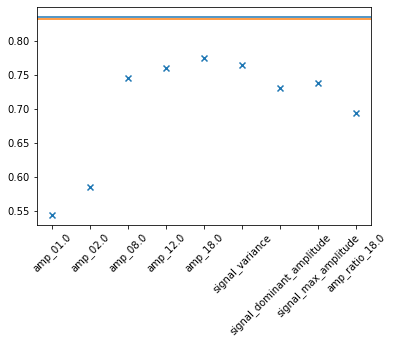

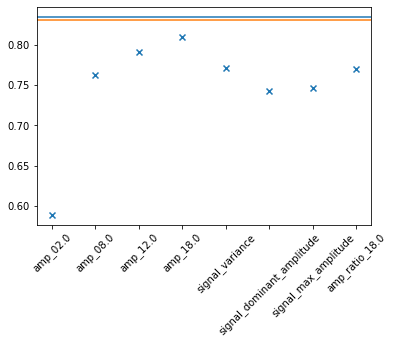

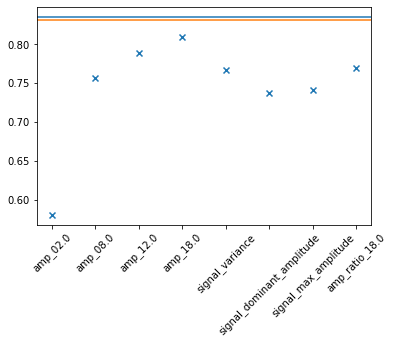

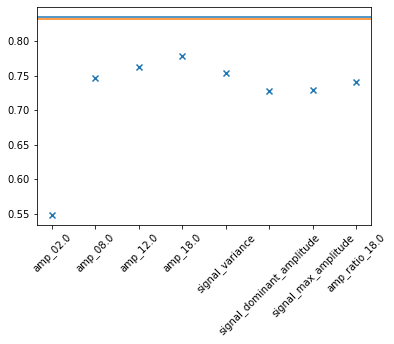

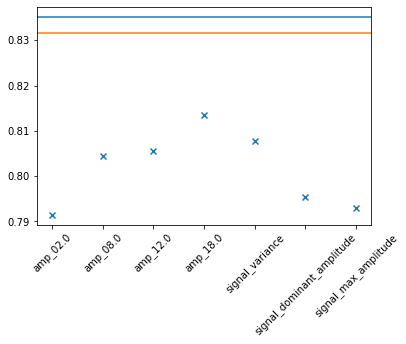

In [61]:
base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 'amp_ratio_01.0']

correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 
                 'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

cv_means_amp01  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

cv_means_nodepth_noba = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 
                 'amp_ratio_01.0', "amp_01.0", "amp_ratio_18.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_amp01_ampr18  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

# SR distance is important 
# base_features = ["receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

# correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
#                        "signal_dominant_amplitude", "signal_max_amplitude"]

# cv_means_nodepth_nosrd = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
#                            top_features_cv=top_feat_sr_cv)

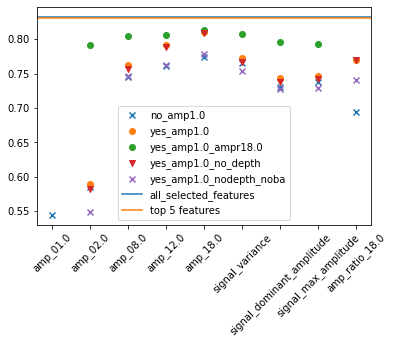

In [62]:
correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude", "amp_ratio_18.0"]

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01, marker="o", label="yes_amp1.0")
plt.scatter( range(1,len(correlated_features)-1), cv_means_amp01_ampr18, marker="o", label="yes_amp1.0_ampr18.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp1.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noba, marker="x", label="yes_amp1.0_nodepth_noba")
# plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nosrd, marker="x", label="yes_amp1.0_nodepth_nosr")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_lat_lon_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_lat_lon_cv), color="C1", label="top 5 features")
plt.legend();

In [70]:
fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', 
                          "amp_01.0", "signal_variance", "amp_18.0"]
fewer_feat_sr_df = train_feat_df.copy()[fewer_features_sr]
fewer_feat_sr_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_sr_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_receiver_distance_logkm,receiver_back_azimuth,amp_ratio_01.0,amp_01.0,signal_variance,amp_18.0,magnitude
source_receiver_distance_logkm,1.000000,0.570750,-0.199336,-0.240020,-0.303985,-0.397196,0.245019
receiver_back_azimuth,0.570750,1.000000,-0.103999,-0.183958,-0.214975,-0.273742,0.115185
amp_ratio_01.0,-0.199336,-0.103999,1.000000,0.559938,0.304558,0.230164,0.247971
amp_01.0,-0.240020,-0.183958,0.559938,1.000000,0.653688,0.524985,0.541990
signal_variance,-0.303985,-0.214975,0.304558,0.653688,1.000000,0.913255,0.684136
amp_18.0,-0.397196,-0.273742,0.230164,0.524985,0.913255,1.000000,0.630565
magnitude,0.245019,0.115185,0.247971,0.541990,0.684136,0.630565,1.000000


In [71]:
fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewer_features_sr], train_y, folds)
print(fewer_feat_sr_cv)
print(np.mean(fewer_feat_sr_cv))

[0.8456503  0.82002706 0.81686858 0.79251534 0.81497275]
0.8180068094433173


## Default C, gamma, and epsilon seem to work well for SVR with RBF

In [99]:
#C_range = [1.0]#np.logspace(-2, 10, 5)
gamma_range = [7.4e-05, 0.1, 0.2, 0.3, 0.4, 5e-1, 1, "scale", "auto"]#np.logspace(-9, 3, 5)
epsilon_range = [5e-3, 1e-2, 5e-2, 1e-1, 2e-1]
param_grid = {"svr__gamma":gamma_range,  "svr__epsilon":epsilon_range} #"svr__C":C_range,
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', SVR(C=1.0))])
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring="r2", n_jobs=3, cv=folds)
svr_cv_results = grid.fit(train_feat_df_unscaled[fewer_features_sr], train_y)

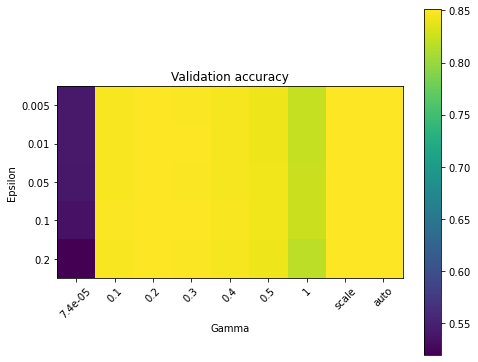

In [100]:
scores = grid.cv_results_["mean_test_score"].reshape(len(epsilon_range), len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.viridis,
    #norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("Gamma")
plt.ylabel("Epsilon")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(epsilon_range)), epsilon_range)
plt.title("Validation accuracy")
plt.show()

## XGBoost

Try more hyperparameters, try with limited features

In [54]:
from xgboost import XGBRegressor
from xgboost import DMatrix
import xgboost

In [34]:
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

In [77]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]], train_y[folds[0][1]])

0.8436004781775079

In [81]:
train_feat_df.columns[43]

'source_depth_km'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

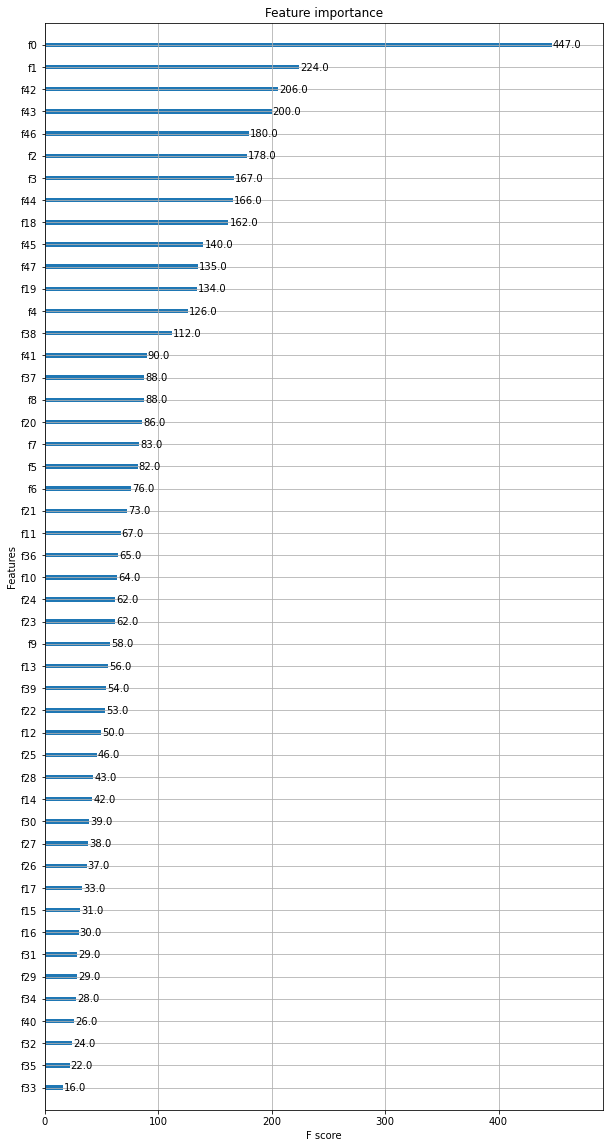

In [78]:
fig, ax = plt.subplots(1, figsize=(10, 20))
xgboost.plot_importance(xgb, ax=ax)

In [93]:
feat_bool = np.isin(train_feat_df.columns, fewer_features_sr)
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]][:, feat_bool], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]][:, feat_bool], train_y[folds[0][1]])

0.8267700491252781

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

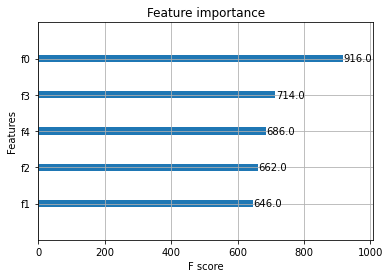

In [95]:
xgboost.plot_importance(xgb)

In [96]:
feat_bool = np.isin(train_feat_df.columns, fewer_features_lat_lon)
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]][:, feat_bool], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]][:, feat_bool], train_y[folds[0][1]])

0.828211006778645

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

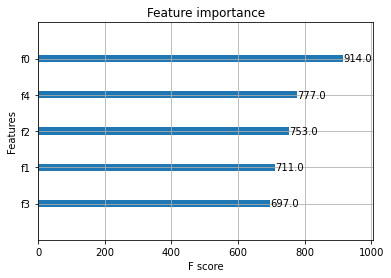

In [97]:
xgboost.plot_importance(xgb)

In [99]:
grid_params = {'max_depth': [1, 2, 3, 5, 10], 
          'eta': [0.05, 0.1, 0.2, 0.3, 0.5],
          'gamma': [0, 0.2, 0.5, 1, 1.5, 2, 5], 
         'min_child_weight':[0, 0.5, 1, 2], 
         'max_delta_step': [0, 1, 2], 
          'subsample': [0.5, 1]}

params = {'max_depth': stats.randint(3, 18),
          'gamma': stats.uniform(0, 5),
          'learning_rate': loguniform(1e-2, 1e0),
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree':stats.uniform(0.5,1),
          'min_child_weight':stats.randint(0, 10), 
          'n_estimators': [100, 250, 500, 750],
          }
    
# params = {'objective': 'reg:squarederror'}
# params['eval_metric'] = 'rmse'
# params['nthread'] = 2

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse') #, topnthread=2
# grid_search = GridSearchCV(xgb, param_grid=grid_params, scoring="r2", 
#                            n_jobs=3, cv=folds).fit(train_feat_matrix_unscaled, train_y)
rand_search = RandomizedSearchCV(xgb, param_distributions=params, scoring="r2", 
                           n_jobs=3, cv=folds).fit(train_feat_matrix_unscaled[:, feat_bool], train_y)

/home/armstrong/anaconda3/envs/ngb-swarm/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/armstrong/anaconda3/envs/ngb-swarm/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/armstrong/anaconda3/envs/ngb-swarm/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
grid_search.best_estimator_

In [ ]:
# {'eta': 0.1,
#  'gamma': 0.5,
#  'max_delta_step': 1,
#  'max_depth': 5,
#  'min_child_weight': 0.5}

# 0.8620877350386309

In [ ]:
grid_search.best_params_

In [356]:
grid_search.best_score_

0.8620877350386309

In [360]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_gamma,param_max_delta_step,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,0.864295,0.024485,0.001776,0.000027,0.1,0.5,1,5,1,"{'eta': 0.1, 'gamma': 0.5, 'max_delta_step': 1...",0.851508,0.876585,0.859669,0.857501,0.865175,0.862088,0.008468,1
21,0.848176,0.012971,0.001773,0.000039,0.1,0.5,1,5,0.5,"{'eta': 0.1, 'gamma': 0.5, 'max_delta_step': 1...",0.851508,0.876585,0.859669,0.857501,0.865175,0.862088,0.008468,1
23,0.915045,0.057268,0.001930,0.000157,0.1,0.5,1,5,2,"{'eta': 0.1, 'gamma': 0.5, 'max_delta_step': 1...",0.850719,0.875802,0.856524,0.855749,0.866509,0.861061,0.008975,3
143,0.824279,0.018338,0.001649,0.000033,0.2,0.5,1,5,2,"{'eta': 0.2, 'gamma': 0.5, 'max_delta_step': 1...",0.849515,0.871540,0.853172,0.856708,0.866093,0.859406,0.008196,4
9,0.835923,0.016201,0.001744,0.000031,0.1,0.5,0,5,0.5,"{'eta': 0.1, 'gamma': 0.5, 'max_delta_step': 0...",0.848715,0.873781,0.859140,0.856353,0.859023,0.859402,0.008130,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,0.171351,0.001210,0.001447,0.000025,0.5,5,1,1,2,"{'eta': 0.5, 'gamma': 5, 'max_delta_step': 1, ...",0.728570,0.771963,0.744521,0.754600,0.749059,0.749743,0.014095,475
468,0.171236,0.000884,0.001473,0.000046,0.5,5,1,1,0.5,"{'eta': 0.5, 'gamma': 5, 'max_delta_step': 1, ...",0.728570,0.771963,0.744521,0.754600,0.749059,0.749743,0.014095,475
458,0.170862,0.002862,0.001508,0.000085,0.5,5,0,1,2,"{'eta': 0.5, 'gamma': 5, 'max_delta_step': 0, ...",0.721374,0.747341,0.719273,0.739084,0.738465,0.733107,0.010918,478
456,0.171211,0.002286,0.001470,0.000027,0.5,5,0,1,0.5,"{'eta': 0.5, 'gamma': 5, 'max_delta_step': 0, ...",0.721374,0.747341,0.719273,0.739084,0.738465,0.733107,0.010918,478


In [55]:
num_round = 100
dtrain = DMatrix(train_feat_matrix_unscaled, label=train_y, feature_names=train_feat_df_unscaled.columns)
bst_cv = xgboost.cv(param, dtrain, num_round, folds=folds, early_stopping_rounds=3, 
               callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

NameError: name 'param' is not defined

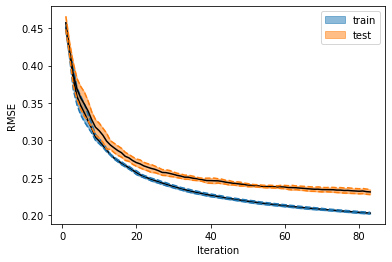

In [330]:
x_ticks = range(1, len(bst_cv)+1)
plt.plot(x_ticks, bst_cv["train-rmse-mean"], color="k")
plt.plot(x_ticks, bst_cv["train-rmse-mean"]+bst_cv["train-rmse-std"], linestyle="--", color="C0")
plt.plot(x_ticks, bst_cv["train-rmse-mean"]-bst_cv["train-rmse-std"], linestyle="--", color="C0")
plt.fill_between(x_ticks,bst_cv["train-rmse-mean"]+bst_cv["train-rmse-std"], 
                 bst_cv["train-rmse-mean"]-bst_cv["train-rmse-std"], color="C0", alpha=0.5, label="train")

plt.plot(x_ticks, bst_cv["test-rmse-mean"], color="k")
plt.plot(x_ticks, bst_cv["test-rmse-mean"]+bst_cv["test-rmse-std"], linestyle="--", color="C1")
plt.plot(x_ticks, bst_cv["test-rmse-mean"]-bst_cv["test-rmse-std"], linestyle="--", color="C1")
plt.fill_between(x_ticks, bst_cv["test-rmse-mean"]+bst_cv["test-rmse-std"], 
                 bst_cv["test-rmse-mean"]-bst_cv["test-rmse-std"], color="C1", alpha=0.5, label="test")

plt.ylabel("RMSE")
plt.xlabel("Iteration")

#plt.xticks(x_ticks)
plt.legend()